# Load libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import twitter_samples
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

import utils

# Load dataset - About the Twitter dataset

In [2]:
pos_tweets=twitter_samples.strings("positive_tweets.json")
neg_tweets=twitter_samples.strings("negative_tweets.json")

tweet_labels = np.append(np.ones((len(pos_tweets))), np.zeros((len(neg_tweets))))

all_tweets = pos_tweets + neg_tweets

In [3]:
clean_tweets = [" ".join(utils.preprocess_tweet(tweet)) for tweet in tqdm(all_tweets)]

100%|██████████| 10000/10000 [00:14<00:00, 681.71it/s]


In [4]:
print(all_tweets[0])
print(clean_tweets[0])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
followfriday for being top engaged member in my community this week :)


# 1) Feature Extraction

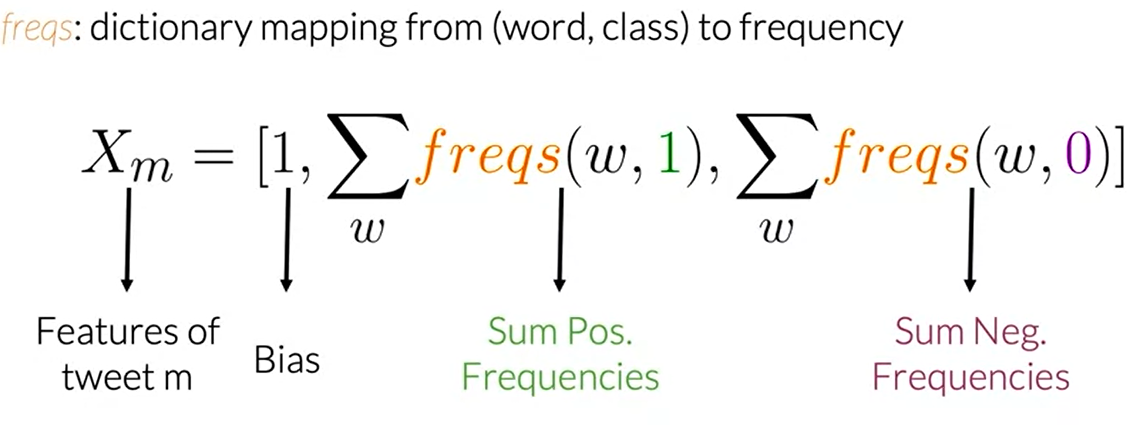

### Create relative frequence

In [5]:
freqs = utils.build_freqs(all_tweets,tweet_labels)

10000it [00:12, 783.59it/s]


In [6]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    clean_tweet = utils.preprocess_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # loop through each word in the list of words
    for word in clean_tweet:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word, 1.0)) if (word, 1) in freqs else 0
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word, 0.0)) if (word, 0.0) in freqs else 0
        
    ### END CODE HERE ###
    #assert(x.shape == (1, 3))
    return x.tolist()

In [7]:
feature = []
for tweet in tqdm(all_tweets):
    feature.append(extract_features(tweet,freqs))

100%|██████████| 10000/10000 [00:13<00:00, 738.02it/s]


In [8]:
features = [lst[0] for lst in feature]

In [9]:
df_features = pd.DataFrame(columns=['bias','positive','negative','sentiment'])

In [10]:
features[0]+[1]

[1.0, 5936.0, 2021.0, 1]

In [11]:
for i in tqdm(range(len(features))):
    if i<5000:
        df_features.loc[i] = features[i] + [1]
    else:
        df_features.loc[i] = features[i] + [0]

100%|██████████| 10000/10000 [00:28<00:00, 356.89it/s]


In [18]:
len(all_tweets[:5000])

5000

In [19]:
len(all_tweets[5000:])

5000

In [12]:
df_features.head()

,bias,positive,negative,sentiment
0,1.0,5936.0,2021.0,1.0
1,1.0,12238.0,5645.0,1.0
2,1.0,13955.0,7130.0,1.0
3,1.0,3589.0,4.0,1.0
4,1.0,12334.0,5776.0,1.0


In [21]:
df_features2 = df_features.copy()
df_features2["tweet"] = all_tweets

In [22]:
df_features2.head()

,bias,positive,negative,sentiment,tweet
0,1.0,5936.0,2021.0,1.0,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,1.0,12238.0,5645.0,1.0,@Lamb2ja Hey James! How odd :/ Please call our...
2,1.0,13955.0,7130.0,1.0,@DespiteOfficial we had a listen last night :)...
3,1.0,3589.0,4.0,1.0,@97sides CONGRATS :)
4,1.0,12334.0,5776.0,1.0,yeaaaah yippppy!!! my accnt verified rqst has...


<AxesSubplot:xlabel='positive', ylabel='negative'>

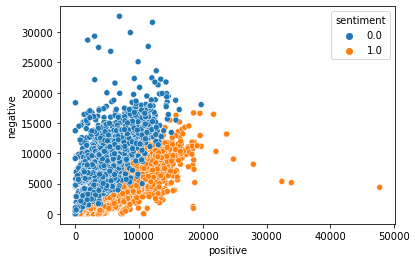

In [204]:
sns.scatterplot(x='positive',y='negative',hue='sentiment',data=df_features)

# 2) Feature Extraction - CountVectorizer

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [110]:
cv = CountVectorizer(analyzer='word',ngram_range=(1, 3))

In [111]:
X_features_cv = cv.fit_transform(clean_tweets)

In [112]:
print(X_features.shape)

(10000, 11111)


# 3) Feature Extraction - TfidfVectorizer

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [123]:
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3))
X_features_tfidf = tfidf.fit_transform(clean_tweets)

In [124]:
X_features_tfidf.shape

(10000, 116930)

# Classification

In [162]:
accuracy = pd.DataFrame(columns=['Feature Extraction 1','Feature Extraction 2','Feature Extraction 3'])

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [164]:
y = tweet_labels

In [180]:
#spliting dataset for training using all feature extraction methods

#feature extraction method 1
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_features[['bias','positive','negative']], y, test_size=0.33, random_state=42)

#feature extraction method 2 - CountVectorizer
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_features_cv, y, test_size=0.33, random_state=42)

#feature extraction method 3 - TfidfVectorizer
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_features_tfidf, y, test_size=0.33, random_state=42)

## Model 1: Logistic regression

In [181]:
#training using feature extraction method 1
LR_1 = LogisticRegression(random_state=0,max_iter=1000).fit(X_train_1, y_train_1)

#training using feature extraction method 2 i.e CountVectorizer
LR_2 = LogisticRegression(random_state=0,max_iter=1000).fit(X_train_2, y_train_2)

#training using feature extraction method 2 i.e TfidfVectorizer
LR_3 = LogisticRegression(random_state=0,max_iter=1000).fit(X_train_3, y_train_3)

In [168]:
#testing the classifier
y_pred_1   = LR_1.predict(X_test_1)
y_pred_1_1 = LR_1.predict(X_train_1)

y_pred_2   = LR_2.predict(X_test_2)
y_pred_2_2 = LR_2.predict(X_train_2)
y_pred_3   = LR_3.predict(X_test_3)
y_pred_3_3 = LR_3.predict(X_train_3)

In [182]:
#f1 score
print("LR F1 test score using Feature 1 =",f1_score(y_test_1, y_pred_1))
print("LR F1 test score using Feature 1 =",f1_score(y_test_2, y_pred_2))
print("LR F1 test score using Feature 1 =",f1_score(y_test_3, y_pred_3))

LR F1 test score using Feature 1 = 0.9656804733727811
LR F1 test score using Feature 1 = 0.7186569184944491
LR F1 test score using Feature 1 = 0.7354607813898003


In [170]:
accuracy.loc['Logistic Rregression'] = [f1_score(y_test_1, y_pred_1),f1_score(y_test_2, y_pred_2),f1_score(y_test_3, y_pred_3)]

## Model 2: SVM

In [183]:
#training SVM model using feature extraction method 1
SVC_1 = SVC(random_state=0,max_iter=1000).fit(X_train_1, y_train_1)

#training SVM using feature extraction method 2 i.e CountVectorizer
SVC_2 = SVC(random_state=0,max_iter=1000).fit(X_train_2, y_train_2)

#training SVM using feature extraction method 3 i.e TfidfVectorizer
SVC_3 = SVC(random_state=0,max_iter=1000).fit(X_train_3, y_train_3)

C:\Users\abhas\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [173]:
y_pred_1   = SVC_1.predict(X_test_1)
y_pred_1_1 = SVC_1.predict(X_train_1)

y_pred_2   = SVC_2.predict(X_test_2)
y_pred_2_2 = SVC_2.predict(X_train_2)
y_pred_3   = SVC_3.predict(X_test_3)
y_pred_3_3 = SVC_3.predict(X_train_3)

In [174]:
print("LR F1 test score using Feature 1 =",f1_score(y_test_1, y_pred_1))
print("LR F1 test score using Feature 1 =",f1_score(y_test_2, y_pred_2))
print("LR F1 test score using Feature 1 =",f1_score(y_test_3, y_pred_3))

LR F1 test score using Feature 1 = 0.9656804733727811
LR F1 test score using Feature 1 = 0.7186569184944491
LR F1 test score using Feature 1 = 0.7354607813898003


In [175]:
accuracy.loc['Support Vector Machine'] =  [f1_score(y_test_1, y_pred_1),f1_score(y_test_2, y_pred_2),f1_score(y_test_3, y_pred_3)]

In [176]:
accuracy

,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3
Logistic Rregression,0.963919,0.764760,0.751363
Support Vector Machine,0.965680,0.718657,0.735461


<AxesSubplot:>

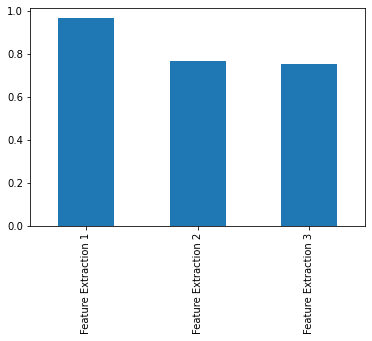

In [177]:
accuracy.loc['Logistic Rregression'].plot.bar()

<AxesSubplot:>

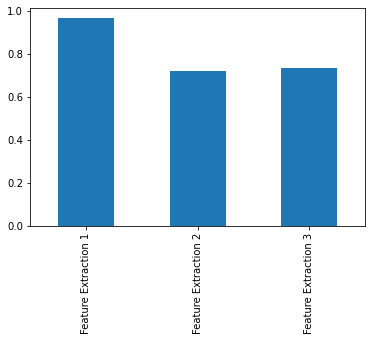

In [178]:
accuracy.loc['Support Vector Machine'].plot.bar()

### From the above graph and through below table, we can say that Feature Extraction 1 method gives more accurate result